# Hugging Faces Experiment

## Language detection
> langua detection experiment using 'papluca/xlm-roberta-base-language-detection'

In [15]:
from datasets import load_dataset
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [19]:
model = pipeline(
    "text-classification",
    model="papluca/xlm-roberta-base-language-detection",
    device=torch.device('cpu')
)

In [20]:
ds = load_dataset('papluca/language-identification', split=['train[0:10]', 'test[0:10]'])

Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 1051.91it/s]
Generating train split: 0 examples [00:00, ? examples/s]/usr/local/lib/python3.8/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
Generating test split: 0 examples [00:00, ? examples/s]             /usr/local/lib/python3.8/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
Generating validation split: 0 examples [00:00, ? examples/s]/usr/local/lib/python3.8/dist-packages/datasets/download

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/papluca___csv/papluca--language-identification-ad5bdc8c9b1a4985/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 293.87it/s]


In [22]:
df = pd.DataFrame(ds[1])
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  10 non-null     object
 1   text    10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


,labels,text
count,10,10
unique,7,10
top,nl,Een man zingt en speelt gitaar.
freq,3,1


In [23]:
test_text = df[df.labels.isin(['de', 'en', 'fr', 'it'])].head(50)['text'].values.tolist()
test_labels = df[df.labels.isin(['de', 'en', 'fr', 'it'])].head(50)['labels'].values.tolist()
len(test_text)

2

In [24]:
to_validate = model(test_text)

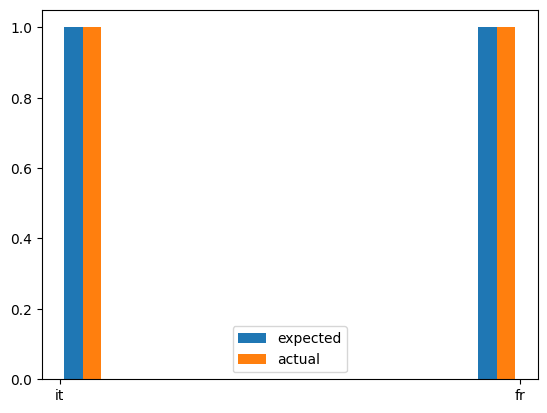

In [42]:
plt.hist([[i['label'] for i in to_validate], test_labels])
plt.legend(['expected', 'actual'])
plt.show()

In [43]:
for i in range(len(to_validate)):
    if to_validate[i]['label'] not in ['it', 'fr', 'en', 'de']:
        print('predicted:', to_validate[i]['label'], '| expedted:', test_labels[i], '| text:', test_text[i])

## Train existing model

In [1]:
from transformers import AutoTokenizer, Trainer, AutoModelForSequenceClassification, XLMRobertaForSequenceClassification
from datasets import load_dataset
from torch.optim import AdamW

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained('papluca/xlm-roberta-base-language-detection')
def tokenize(data):
    return tokenizer(data['text'], truncation=True, padding='max_length')

In [3]:
ds = load_dataset('papluca/language-identification', split=['train[0:10]', 'test[0:10]'])
train_tokenized_dataset = ds[0].map(tokenize)
test_tokenized_dataset = ds[1].map(tokenize)

Found cached dataset csv (/root/.cache/huggingface/datasets/papluca___csv/papluca--language-identification-ad5bdc8c9b1a4985/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 2/2 [00:00<00:00, 99.22it/s]
Loading cached processed dataset at /root/.cache/huggingface/datasets/papluca___csv/papluca--language-identification-ad5bdc8c9b1a4985/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-423cf3fc6fb120f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/papluca___csv/papluca--language-identification-ad5bdc8c9b1a4985/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-b807b8e3beae6bbb.arrow


In [4]:
model = XLMRobertaForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection")

In [5]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [6]:
trainer = Trainer(
    model=model,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    optimizers=(optimizer, None)
)

In [7]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.